In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Pennsylvania
state_ab = "pa"

## Data
1. Download all the data in directory "pa_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/carter_boundaries.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/2022 LRC-Senate-Final.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/2022 LRC-House-Final.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|█████████████████████████████████| 336985/336985 [02:03<00:00, 2734.32it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 333.52it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'MCD', 'TYPE', 'PRECINCT', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20ATGDSHA', 'G20ATGRHEI', 'G20ATGLWAS',
       'G20ATGGWEI', 'G20AUDDAHM', 'G20AUDRDEF', 'G20AUDLMOO', 'G20AUDGFAI',
       'G20TREDTOR', 'G20TRERGAR', 'G20TRELSOL', 'G20TREGRUN', 'geometry'],
      dtype='object')

In [27]:
start_col = 6
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 322.33it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 828.84it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 9786/9786 [00:05<00:00, 1942.65it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 1: 100%|██████████████| 1/1 [00:00<00:00, 146.31it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 2: 100%|██████████████████| 1/1 [00:00<00:00, 124.21it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 5: 100%|████████████| 10/10 [00:00<00:00, 104.79it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 9: 100%|███████████████████| 2/2 [00:00<00:00, 75.31it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 12: 100%|████████████████| 21/21 [00:00<00:00, 56.65it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Ga

In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[3500:5000])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 9318/9318 [00:02<00:00, 3924.47it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|█████████████████████████████████████| 9157/9157 [00:06<00:00, 1498.11it/s]


In [31]:

maup.doctor(vest_base)

100%|█████████████████████████████████████| 9157/9157 [00:05<00:00, 1827.48it/s]


True

In [32]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 9157/9157 [00:24<00:00, 372.28it/s]


In [33]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 9157/9157 [00:23<00:00, 385.95it/s]


In [34]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [35]:
election_df = gpd.GeoDataFrame(vest_base)

In [36]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20D', 'AUD20O', 'AUD20R', 'COUNTYFP',
       'MCD', 'NAME', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'STATEFP',
       'TRE20D', 'TRE20O', 'TRE20R', 'TYPE', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if Population Agrees

In [38]:
check_population(population_df, vest_base)

population agrees


In [39]:
vest18 = gpd.read_file(vest18_data)

In [40]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'MCD', 'TYPE', 'PRECINCT', 'NAME', 'G18USSRBAR',
       'G18USSDCAS', 'G18USSLKER', 'G18USSGGAL', 'G18GOVRWAG', 'G18GOVDWOL',
       'G18GOVLKRA', 'G18GOVGGLO', 'geometry'],
      dtype='object')

In [41]:
start_col = 6
vest_base_data = vest18

In [42]:
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 9160/9160 [00:05<00:00, 1746.68it/s]


There are 291 overlaps.
There are 29 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 9505/9505 [00:02<00:00, 4205.52it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 9157/9157 [00:26<00:00, 351.04it/s]


population agrees


In [43]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG20D', 'ATG20O', 'ATG20R',
       'AUD20D', 'AUD20O', 'AUD20R', 'BVAP', 'COUNTYFP', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'MCD', 'NAME', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'STATEFP',
       'TOTPOP', 'TRE20D', 'TRE20O', 'TRE20R', 'TYPE', 'USS18D', 'USS18O',
       'USS18R', 'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [44]:
vest16 = gpd.read_file(vest16_data)

In [45]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'MCD', 'TYPE', 'PRECINCT', 'NAME', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PRECCAS', 'G16USSRTOO',
       'G16USSDMCG', 'G16USSLCLI', 'G16ATGRRAF', 'G16ATGDSHA', 'G16AUDRBRO',
       'G16AUDDDEP', 'G16AUDLMIN', 'G16AUDGSWE', 'G16TRERVOI', 'G16TREDTOR',
       'G16TRELBAB', 'G16TREGCOM', 'geometry'],
      dtype='object')

In [46]:
election_df = add_vest(vest16, election_df, '16', population_df, 6)

100%|█████████████████████████████████████| 9166/9166 [00:05<00:00, 1601.31it/s]


There are 301 overlaps.
There are 29 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 9515/9515 [00:02<00:00, 3931.35it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 9157/9157 [00:23<00:00, 386.57it/s]


population agrees


##  Add the district data

In [48]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [49]:
cong_df.head()

,ID,AREA,DISTRICT,geometry
0,2,67.39,2,"POLYGON ((502219.399 4433151.135, 501924.857 4..."
1,3,2836.43,8,"POLYGON ((472269.989 4646522.845, 472304.971 4..."
2,5,1183.00,7,"POLYGON ((450008.636 4481719.177, 449840.585 4..."
3,8,54.74,3,"POLYGON ((481165.177 4428218.280, 481287.767 4..."
4,10,717.30,1,"POLYGON ((483351.034 4495325.819, 483359.048 4..."


In [50]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 17/17 [00:01<00:00, 12.37it/s]


In [51]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJ_NH_WHT,ADJ_NH_BLK,ADJ_NH_IND,...,F_ADJ_NH18,F_ADJ_NH11,F_ADJ_NH12,F_ADJ_NH13,F_ADJ_NH14,F_ADJ_NH15,F_ADJ_NH16,F_ADJ_H18_,DISTRICT_L,geometry
0,1,26.593678,1,1.0,Y,None,250243,160098,20752,240,...,0.665370,0.081346,0.000853,0.128803,0.000216,0.005139,0.030306,0.087967,1|-3.77%,"POLYGON ((492001.708 4424915.081, 491770.593 4..."
1,2,227.877075,10,1.0,Y,None,269925,214251,13538,202,...,0.819453,0.047707,0.000803,0.046760,0.000163,0.003691,0.027043,0.054380,10|3.8%,"POLYGON ((477532.399 4459627.510, 477637.665 4..."
2,3,204.734299,11,1.0,Y,None,263931,144950,15107,291,...,0.602257,0.058512,0.001000,0.017471,0.000153,0.003015,0.021855,0.295737,11|1.49%,"POLYGON ((437418.391 4492390.823, 437536.441 4..."
3,4,145.972626,12,1.0,Y,None,263688,196324,14613,227,...,0.768420,0.053581,0.000898,0.106883,0.000192,0.003035,0.023236,0.043754,12|1.4%,"POLYGON ((465849.524 4468860.385, 465872.860 4..."
4,5,606.769287,13,1.0,Y,None,262878,194884,13165,274,...,0.764510,0.049672,0.001153,0.023455,0.000160,0.003139,0.021976,0.135935,13|1.09%,"POLYGON ((415839.022 4421326.004, 415844.569 4..."


In [52]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 31.24it/s]


In [53]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJ_NH_WHT,ADJ_NH_BLK,ADJ_NH_IND,...,F_ADJ_NH11,F_ADJ_NH12,F_ADJ_NH13,F_ADJ_NH14,F_ADJ_NH15,F_ADJ_NH16,F_ADJ_H18_,DISTRICT_N,DISTRICT_L,geometry
0,1,766.475586,1,1.0,Y,None,65227,42592,10660,97,...,0.143063,0.001576,0.029188,0.000414,0.005258,0.041300,0.067750,1,1|1.83%,"POLYGON ((61425.810 4668741.141, 61402.884 466..."
1,2,2.996813,10,1.0,Y,None,61532,15630,35227,121,...,0.527985,0.001954,0.097049,0.000586,0.004534,0.031171,0.045144,10,10|-3.94%,"POLYGON ((479629.944 4422621.752, 479461.489 4..."
2,3,309.422150,100,1.0,Y,None,64207,59347,577,60,...,0.009113,0.001008,0.003461,0.000044,0.001818,0.018993,0.031655,100,100|0.24%,"POLYGON ((415839.022 4421326.004, 415844.569 4..."
3,4,70.999825,101,1.0,Y,None,65422,43860,1800,63,...,0.026436,0.001067,0.014601,0.000178,0.002331,0.017031,0.217691,101,101|2.14%,"POLYGON ((375252.199 4454138.935, 375232.326 4..."
4,5,247.142853,102,1.0,Y,None,65771,59409,666,54,...,0.009238,0.000935,0.012473,0.000468,0.002865,0.020093,0.037127,102,102|2.68%,"POLYGON ((373860.234 4465456.786, 373846.877 4..."


In [54]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 83.58it/s]


In [55]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG16D', 'ATG16R', 'ATG20D',
       'ATG20O', 'ATG20R', 'AUD16D', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'MCD', 'NAME', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D',
       'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'STATEFP',
       'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R', 'TRE20D', 'TRE20O', 'TRE20R',
       'TYPE', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O', 'USS18R',
       'VAP', 'WVAP', 'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [57]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP' + year, 
        'COUNTYFP':'COUNTYFP' + year, 
        'MCD':'MCD' + year, 
        'TYPE':'TYPE' + year, 
        'PRECINCT':'PRECINCT' + year, 
        'NAME':'NAME' + year}
election_df.rename(columns=base_columns, inplace = True)

In [58]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG16D', 'ATG16R', 'ATG20D',
       'ATG20O', 'ATG20R', 'AUD16D', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'MCD20', 'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'STATEFP20', 'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R',
       'TRE20D', 'TRE20O', 'TRE20R', 'TYPE20', 'USS16D', 'USS16O', 'USS16R',
       'USS18D', 'USS18O', 'USS18R', 'VAP', 'WVAP', 'geometry', 'CD', 'SEND',
       'HDIST'],
      dtype='object')

In [59]:
# reorder the columns
fixed_columns = [
    'STATEFP' + year, 
    'COUNTYFP' + year, 
    'MCD' + year, 
    'TYPE' + year, 
    'PRECINCT' + year, 
    'NAME' + year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [60]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

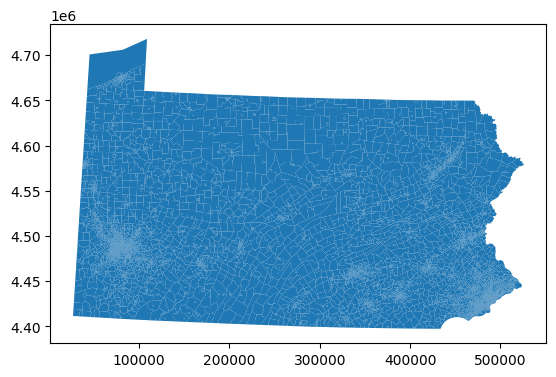

In [61]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()

In [62]:
print(list(election_df.columns))

['STATEFP20', 'COUNTYFP20', 'MCD20', 'TYPE20', 'PRECINCT20', 'NAME20', 'CD', 'SEND', 'HDIST', 'TOTPOP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'HISP', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'ATG16D', 'ATG16R', 'ATG20D', 'ATG20O', 'ATG20R', 'AUD16D', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O', 'AUD20R', 'GOV18D', 'GOV18O', 'GOV18R', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE16D', 'TRE16O', 'TRE16R', 'TRE20D', 'TRE20O', 'TRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O', 'USS18R', 'geometry']


In [63]:
len(election_df.columns)


67